In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import argparse
import sys
import time
import copy

import numpy as np

from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem
from rdkit.Chem.Crippen import MolLogP

from sklearn.metrics import mean_absolute_error

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable

from tqdm import tnrange, tqdm_notebook
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
paser = argparse.ArgumentParser()
args = paser.parse_args("")
args.seed = 123
args.val_size = 0.1
args.test_size = 0.1
args.shuffle = True

In [4]:
np.random.seed(args.seed)
torch.manual_seed(args.seed)

if torch.cuda.is_available():
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
else:
    torch.set_default_tensor_type('torch.FloatTensor')

# 1. Pre-Processing

In this step, smiles data is read from the ZINC.smiles file and converted to a pytorch Dataset which contain feature tensor, adjacency matrix, and logP value of each molecules. A smiles string is converted to feature tensor as follows:
<img src="files/Graph_Generating_Process.png">

In [5]:
def read_ZINC_smiles(file_name, num_mol):
    f = open(file_name, 'r')
    contents = f.readlines()

    smi_list = []
    logP_list = []

    for i in tqdm_notebook(range(num_mol), desc='Reading Data'):
        smi = contents[i].strip()
        m = Chem.MolFromSmiles(smi)
        smi_list.append(smi)
        logP_list.append(MolLogP(m))

    logP_list = np.asarray(logP_list).astype(float)

    return smi_list, logP_list


def smiles_to_onehot(smi_list):
    def smiles_to_vector(smiles, vocab, max_length):
        while len(smiles) < max_length:
            smiles += " "
        vector = [vocab.index(str(x)) for x in smiles]
        one_hot = np.zeros((len(vocab), max_length), dtype=int)
        for i, elm in enumerate(vector):
            one_hot[elm][i] = 1
        return one_hot

    vocab = np.load('./vocab.npy')
    smi_total = []

    for i, smi in tqdm_notebook(enumerate(smi_list), desc='Converting to One Hot'):
        smi_onehot = smiles_to_vector(smi, list(vocab), 120)
        smi_total.append(smi_onehot)

    return np.asarray(smi_total)

def convert_to_graph(smiles_list):
    adj = []
    adj_norm = []
    features = []
    maxNumAtoms = 50
    for i in tqdm_notebook(smiles_list, desc='Converting to Graph'):
        # Mol
        iMol = Chem.MolFromSmiles(i.strip())
        #Adj
        iAdjTmp = Chem.rdmolops.GetAdjacencyMatrix(iMol)
        # Feature
        if( iAdjTmp.shape[0] <= maxNumAtoms):
            # Feature-preprocessing
            iFeature = np.zeros((maxNumAtoms, 58))
            iFeatureTmp = []
            for atom in iMol.GetAtoms():
                iFeatureTmp.append( atom_feature(atom) ) ### atom features only
            iFeature[0:len(iFeatureTmp), 0:58] = iFeatureTmp ### 0 padding for feature-set
            features.append(iFeature)

            # Adj-preprocessing
            iAdj = np.zeros((maxNumAtoms, maxNumAtoms))
            iAdj[0:len(iFeatureTmp), 0:len(iFeatureTmp)] = iAdjTmp + np.eye(len(iFeatureTmp))
            adj.append(np.asarray(iAdj))
    features = np.asarray(features)

    return features, adj
    
def atom_feature(atom):
    return np.array(one_of_k_encoding_unk(atom.GetSymbol(),
                                      ['C', 'N', 'O', 'S', 'F', 'H', 'Si', 'P', 'Cl', 'Br',
                                       'Li', 'Na', 'K', 'Mg', 'Ca', 'Fe', 'As', 'Al', 'I', 'B',
                                       'V', 'Tl', 'Sb', 'Sn', 'Ag', 'Pd', 'Co', 'Se', 'Ti', 'Zn',
                                       'Ge', 'Cu', 'Au', 'Ni', 'Cd', 'Mn', 'Cr', 'Pt', 'Hg', 'Pb']) +
                    one_of_k_encoding(atom.GetDegree(), [0, 1, 2, 3, 4, 5]) +
                    one_of_k_encoding_unk(atom.GetTotalNumHs(), [0, 1, 2, 3, 4]) +
                    one_of_k_encoding_unk(atom.GetImplicitValence(), [0, 1, 2, 3, 4, 5]) +
                    [atom.GetIsAromatic()])    # (40, 6, 5, 6, 1)

def one_of_k_encoding(x, allowable_set):
    if x not in allowable_set:
        raise Exception("input {0} not in allowable set{1}:".format(x, allowable_set))
    return list(map(lambda s: x == s, allowable_set))

def one_of_k_encoding_unk(x, allowable_set):
    """Maps inputs not in the allowable set to the last element."""
    if x not in allowable_set:
        x = allowable_set[-1]
    return list(map(lambda s: x == s, allowable_set))


class GCNDataset(Dataset):
    def __init__(self, list_feature, list_adj, list_logP):
        self.list_feature = list_feature
        self.list_adj = list_adj
        self.list_logP = list_logP

    def __len__(self):
        return len(self.list_feature)

    def __getitem__(self, index):
        return self.list_feature[index], self.list_adj[index], self.list_logP[index]


def partition(list_feature, list_adj, list_logP, args):
    num_total = list_feature.shape[0]
    num_train = int(num_total * (1 - args.test_size - args.val_size))
    num_val = int(num_total * args.val_size)
    num_test = int(num_total * args.test_size)

    feature_train = list_feature[:num_train]
    adj_train = list_adj[:num_train]
    logP_train = list_logP[:num_train]
    feature_val = list_feature[num_train:num_train + num_val]
    adj_val = list_adj[num_train:num_train + num_val]
    logP_val = list_logP[num_train:num_train + num_val]
    feature_test = list_feature[num_total - num_test:]
    adj_test = list_adj[num_total - num_test:]
    logP_test = list_logP[num_total - num_test:]
        
    train_set = GCNDataset(feature_train, adj_train, logP_train)
    val_set = GCNDataset(feature_val, adj_val, logP_val)
    test_set = GCNDataset(feature_test, adj_test, logP_test)

    partition = {
        'train': train_set,
        'val': val_set,
        'test': test_set
    }

    return partition

In [119]:
list_smi, list_logP = read_ZINC_smiles('ZINC.smiles', 50000)
list_feature, list_adj = convert_to_graph(list_smi)
dict_partition = partition(list_feature, list_adj, list_logP, args)

# 2. Model Construction

The message passing neural network (MPNN) framework updates a node with following formula.

$$ H_i^{(l+1)} = U(H_i^{(l)}, m^{(l+1)}) $$

The i-th node is updated through the message state, $m^{(l+1)}$ from the adjacent nodes and previous node state, $H^{(l)}$. In general, a message state is updated as follows:

$$ m^{(l+1)} = \sum_{j \in N_i} M(H_i^{(l)}, H_j^{(l)}, e_{ij}) $$

From the inital edge information, $ e_{ij} $, a message state can be updated differently for different relations, such as a single bond, double bond and aromatic bond.

In this GGNN framework, only the connectivity between the nodes will be considered. Also, for simplicity, the message state will be defined as a simple summation of the adjacent node states as follows:

$$ m^{(l+1)} = \sum_{j \in N_i} H_j^{(l)} $$

The gated recurrent unit (GRU) will be used to update nodes. Thus the node state will be defined as follows:

$$ H_i^{(l+1)} = GRU(H_i^{(l)}, \sum_{j \in N_i} H_j^{(l)}) $$

Since feeding each state of node and message to a GRU cell takes a long time, a custom GRU cell was used to handle whole nodes at once.

In [6]:
class GatedSkipConnection(nn.Module):
    
    def __init__(self, in_dim, out_dim):
        super(GatedSkipConnection, self).__init__()
        
        self.in_dim = in_dim
        self.out_dim = out_dim
        
        self.linear = nn.Linear(in_dim, out_dim, bias=False)
        self.linear_coef_in = nn.Linear(out_dim, out_dim)
        self.linear_coef_out = nn.Linear(out_dim, out_dim)
        
        nn.init.xavier_normal_(self.linear.weight)
        nn.init.xavier_normal_(self.linear_coef_in.weight)
        nn.init.xavier_normal_(self.linear_coef_out.weight)
        
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, in_x, out_x):
        if (self.in_dim != self.out_dim):
            in_x = self.linear(in_x)
        z = self.gate_coefficient(in_x, out_x)
        out = torch.mul(z, out_x) + torch.mul(1.0-z, in_x)
        return out
            
    def gate_coefficient(self, in_x, out_x):
        x1 = self.linear_coef_in(in_x)
        x2 = self.linear_coef_out(out_x)
        return self.sigmoid(x1+x2)

In [7]:
class GRUCell(nn.Module):
    
    def __init__(self, in_dim, hidden_dim):
        super(GRUCell, self).__init__()
        
        self.linear_update_h = nn.Linear(in_dim, hidden_dim)
        self.linear_update_x = nn.Linear(in_dim, hidden_dim)
        self.linear_reset_h = nn.Linear(in_dim, hidden_dim)
        self.linear_reset_x = nn.Linear(in_dim, hidden_dim)
        self.linear_current_h = nn.Linear(in_dim, hidden_dim)
        self.linear_current_x = nn.Linear(in_dim, hidden_dim)
        
        nn.init.xavier_normal_(self.linear_update_h.weight)
        nn.init.xavier_normal_(self.linear_update_x.weight)
        nn.init.xavier_normal_(self.linear_reset_h.weight)
        nn.init.xavier_normal_(self.linear_reset_x.weight)
        nn.init.xavier_normal_(self.linear_current_h.weight)
        nn.init.xavier_normal_(self.linear_current_x.weight)
        
        self.sigmoid = nn.Sigmoid()
        self.tanh = nn.Tanh()
        
    def forward(self, x, h):
        z = self.update_gate_coefficient(x, h)
        r = self.reset_gate_coefficient(x, h)
        h_prime = self.current_memory_content(x, h, r)
        h_new = self.final_memory_content(h, h_prime, z)
        return h_new
        
    def update_gate_coefficient(self, x, h):
        x_weighted = self.linear_update_x(x)
        h_weighted = self.linear_update_h(h)
        return self.sigmoid(x_weighted + h_weighted)
    
    def reset_gate_coefficient(self, x, h):
        x_weighted = self.linear_reset_x(x)
        h_weighted = self.linear_reset_h(h)
        return self.sigmoid(x_weighted + h_weighted)
    
    def current_memory_content(self, x, h, r):
        x_weighted = self.linear_current_x(x)
        h_weighted = torch.mul(r, self.linear_current_h(h))
        return self.tanh(x_weighted + h_weighted)
    
    def final_memory_content(self, h, h_prime, z):
        current = torch.mul(1.0-z, h_prime)
        previous = torch.mul(z, h)
        return current + previous
        

In [8]:
class GGNNLayer(nn.Module):
    
    def __init__(self, in_dim, out_dim):
        super(GGNNLayer, self).__init__()
        
        self.linear = None
        if in_dim != out_dim:
            self.linear = nn.Linear(in_dim, out_dim, bias=False)
            nn.init.xavier_normal_(self.linear.weight)
        self.gruCell = GRUCell(out_dim, out_dim)
        
    def forward(self, x, adj):
        num_nodes = x.shape[1]
        # x: (batch_size, max_atom, out_dim)
        if self.linear is not None:
            x = self.linear(x)
        
        # The message state is defined as the sum of state of adjacent nodes
        # m: (batch_size, max_atom, out_dim)
        m = torch.matmul(adj, x)
        out = self.gruCell(m, x)
        return out, adj

In [9]:
class GGNNBlock(nn.Module):
    
    def __init__(self, n_layer, in_dim, hidden_dim, activation=None, gsc=True):
        super(GGNNBlock, self).__init__()
        
        self.layers = nn.ModuleList()
        for i in range(n_layer):
            self.layers.append(GGNNLayer(in_dim if i==0 else hidden_dim,
                                         hidden_dim))
        self.act = activation
        self.gsc = None
        if gsc:
            self.gsc = GatedSkipConnection(in_dim, hidden_dim)
            
    def forward(self, x, adj):
        residual = x
        for i, layer in enumerate(self.layers):
            out, adj = layer((x if i==0 else out), adj)
        if not self.gsc is None:
            out = self.gsc(residual, out)
        if not self.act is None:
            out = self.act(out)
        return out, adj

In [10]:
class ReadOut(nn.Module):
    
    def __init__(self, in_dim, out_dim, act=None):
        super(ReadOut, self).__init__()
        
        self.in_dim = in_dim
        self.out_dim= out_dim
        
        self.linear = nn.Linear(self.in_dim, 
                                self.out_dim)
        nn.init.xavier_uniform_(self.linear.weight)
        self.activation = act

    def forward(self, x):
        out = self.linear(x)
        out = torch.sum(out, 1)
        if self.activation != None:
            out = self.activation(out)
        return out

In [11]:
class Predictor(nn.Module):
    
    def __init__(self, in_dim, out_dim, act=None):
        super(Predictor, self).__init__()
        
        self.in_dim = in_dim
        self.out_dim = out_dim
        
        self.linear = nn.Linear(self.in_dim,
                                self.out_dim)
        nn.init.xavier_normal_(self.linear.weight)
        self.activation = act
        
    def forward(self, x):
        out = self.linear(x)
        if self.activation != None:
            out = self.activation(out)
        return out

In [12]:
class GGNNNet(nn.Module):
    
    def __init__(self, args):
        super(GGNNNet, self).__init__()
        
        self.blocks = nn.ModuleList()
        for i in range(args.n_block):
            self.blocks.append(GGNNBlock(n_layer=args.n_layer,
                                         in_dim=args.in_dim if i==0 else args.hidden_dim,
                                         hidden_dim=args.hidden_dim,
                                         activation=nn.ReLU(),
                                         gsc=args.gsc))
            self.readout = ReadOut(args.hidden_dim,
                                   args.pred_dim1,
                                   act=nn.ReLU())
            self.pred1 = Predictor(args.pred_dim1,
                               args.pred_dim2,
                               act=nn.ReLU())
            self.pred2 = Predictor(args.pred_dim2,
                                   args.pred_dim3,
                                   act=nn.Tanh())
            self.pred3 = Predictor(args.pred_dim3,
                                   args.out_dim)
            
    def forward(self, x, adj):
        for i, block in enumerate(self.blocks):
            out, adj = block((x if i==0 else out), adj)
        out = self.readout(out)
        out = self.pred1(out)
        out = self.pred2(out)
        out = self.pred3(out)
        return out

# 3. Train, Validate, and Test

In [13]:
def train(model, device, optimizer, criterion, data_train, bar, args):
    epoch_train_loss = 0
    epoch_train_mae = 0
    for i, batch in enumerate(data_train):
        list_feature = torch.tensor(batch[0]).to(device).float()
        list_adj = torch.tensor(batch[1]).to(device).float()
        list_logP = torch.tensor(batch[2]).to(device).float()
                
        model.train()
        optimizer.zero_grad()
        
        list_pred_logP = model(list_feature, list_adj).squeeze().to(device)
        list_pred_logP.require_grad = False
        
        train_loss = criterion(list_pred_logP, list_logP)
        train_mae = mean_absolute_error(list_pred_logP.tolist(), list_logP.tolist())
        epoch_train_loss += train_loss.item()
        epoch_train_mae += train_mae
        
        train_loss.backward()
        optimizer.step()
       
        bar.update(len(list_feature))

    epoch_train_loss /= len(data_train)
    epoch_train_mae /= len(data_train)
    
    return model, epoch_train_loss, epoch_train_mae

In [14]:
def validate(model, device, criterion, data_val, bar, args):
    epoch_val_loss = 0
    epoch_val_mae = 0
    with torch.no_grad():
        for i, batch in enumerate(data_val):
            list_feature = torch.tensor(batch[0]).to(device).float()
            list_adj = torch.tensor(batch[1]).to(device).float()
            list_logP = torch.tensor(batch[2]).to(device).float()

            model.eval()
            list_pred_logP = model(list_feature, list_adj).squeeze().to(device)
            list_pred_logP.require_grad = False
            
            val_loss = criterion(list_pred_logP, list_logP)
            val_mae = mean_absolute_error(list_pred_logP.tolist(), list_logP.tolist())
            epoch_val_loss += val_loss.item()
            epoch_val_mae += val_mae
            
            bar.update(len(list_feature))

    epoch_val_loss /= len(data_val)
    epoch_val_mae /= len(data_val)
    
    return model, epoch_val_loss, epoch_val_mae

In [15]:
def test(model, device, data_test, args):
    model.eval()
    with torch.no_grad():
        logP_total = list()
        pred_logP_total = list()
        for i, batch in enumerate(data_test):
            list_feature = torch.tensor(batch[0]).to(device).float()
            list_adj = torch.tensor(batch[1]).to(device).float()
            list_logP = torch.tensor(batch[2]).to(device).float()

            list_pred_logP = model(list_feature, list_adj).squeeze().to(device)
            
            pred_logP_total += list_pred_logP.tolist()
            logP_total += list_logP.tolist()

        mae = mean_absolute_error(logP_total, pred_logP_total)
        std = np.std(np.array(logP_total)-np.array(pred_logP_total))
        
    return mae, std, logP_total, pred_logP_total

In [16]:
def experiment(dict_partition, device, bar, args):
    time_start = time.time()
    
    model = GGNNNet(args)
    model.to(device)
        
    if args.optim == 'Adam':
        optimizer = optim.Adam(model.parameters(),
                               lr=args.lr,
                               weight_decay=args.l2_coef)
    elif args.optim == 'RMSprop':
        optimizer = optim.RMSprop(model.parameters(),
                               lr=args.lr,
                               weight_decay=args.l2_coef)
    elif args.optim == 'SGD':
        optimizer = optim.SGD(model.parameters(),
                               lr=args.lr,
                               weight_decay=args.l2_coef)
    else:
        assert False, 'Undefined Optimizer Type'
        
    criterion = nn.MSELoss()
    scheduler = optim.lr_scheduler.StepLR(optimizer,
                                          step_size=args.step_size,
                                          gamma=args.gamma)

    list_train_loss = list()
    list_val_loss = list()
    list_train_mae = list()
    list_val_mae = list()

    data_train = DataLoader(dict_partition['train'], 
                            batch_size=args.batch_size,
                            shuffle=args.shuffle)

    data_val = DataLoader(dict_partition['val'],
                          batch_size=args.batch_size,
                          shuffle=args.shuffle)

    for epoch in range(args.epoch):
        scheduler.step()
        model, train_loss, train_mae = train(model, device, optimizer, criterion, data_train, bar, args)
        list_train_loss.append(train_loss)
        list_train_mae.append(train_mae)
        
        model, val_loss, val_mae = validate(model, device, criterion, data_val, bar, args)
        list_val_loss.append(val_loss)
        list_val_mae.append(val_mae)

    data_test = DataLoader(dict_partition['test'],
                           batch_size=args.batch_size,
                           shuffle=args.shuffle)

    mae, std, logP_total, pred_logP_total = test(model, device, data_test, args)
        
    time_end = time.time()
    time_required = time_end - time_start
    
    args.list_train_loss = list_train_loss
    args.list_val_loss = list_val_loss
    args.list_train_mae = list_train_mae
    args.list_val_mae = list_val_mae
    args.logP_total = logP_total
    args.pred_logP_total = pred_logP_total
    args.mae = mae
    args.std = std
    args.time_required = time_required
    
    return args

# 4. Visualization

In [17]:
def plot_performance(df_result, var1, var2):
    fig, ax = plt.subplots(1, 2)
    fig.set_size_inches(10, 5)
    
    df_mae = df_result.pivot(var1, var2, 'mae')
    df_std = df_result.pivot(var1, var2, 'std')
    df_mae = df_mae[df_mae.columns].astype(float)
    df_std = df_std[df_std.columns].astype(float)
    
    hm_mae = sns.heatmap(df_mae, ax=ax[0], annot=True, fmt='f', linewidths=.5, cmap='YlGnBu')
    hm_std = sns.heatmap(df_std, ax=ax[1], annot=True, fmt='f', linewidths=.5, cmap='YlGnBu')
    
    fig.suptitle('Performance depends on ' + var1 + ' vs ' + var2)
    hm_mae.set_title('MAE depends on ' + var1 + ' vs ' + var2)
    hm_std.set_title('Std depends on ' + var1 + ' vs ' + var2)

In [18]:
def plot_performance_bar(df_result, var1, var2):
    fig, ax = plt.subplots(1, 2)
    fig.set_size_inches(10, 5)
    
    sns.set_style("darkgrid", {"axes.facecolor": ".9"})
    bar_mae = sns.barplot(x=var1, y='mae', hue=var2, data=df_result, ax=ax[0])
    bar_std = sns.barplot(x=var1, y='std', hue=var2, data=df_result, ax=ax[1])
    
    bar_mae.set_title('MAE depends on ' + var1 + ' vs ' + var2)
    bar_std.set_title('Std depends on ' + var1 + ' vs ' + var2)
    fig.suptitle('Performance depends on ' + var1 + ' vs ' + var2)

In [19]:
def plot_loss(df_result, var1, var2, ylim):
    def plot(x, ylim=1.0, **kwargs):
        plt.plot(x[0], **kwargs)
        plt.ylim(0.0, ylim)
    
    sns.set_style("darkgrid", {"axes.facecolor": ".9"})
    g = sns.FacetGrid(df_result, row=var1, col=var2, margin_titles=True)
    g.map(plot, 'list_train_loss', ylim=ylim, label='Train Loss')
    g.map(plot, 'list_val_loss', ylim=ylim, color='r', label='Validation Loss')
    g.map(plot, 'list_val_mae', ylim=ylim, color='g', label='MAE')
    g.fig.suptitle('Loss vs Epochs depends on ' + var1 + ' vs ' + var2, size=16)
    g.fig.subplots_adjust(top=.9)
    plt.legend()
    plt.show()

In [20]:
def plot_distribution(df_result, var1, var2):
    def scatter(x, y, **kwargs):
        plt.scatter(x[0], y[0], alpha=0.3, s=2)
    def identity(x, y, **kwargs):
        plt.plot(x[0], x[0], alpha=0.4, color='black')
    
    sns.set_style("darkgrid", {"axes.facecolor": ".9"})
    g = sns.FacetGrid(df_result, row=var1, col=var2, margin_titles=True)
    g.map(scatter, 'logP_total', 'pred_logP_total')
    g.map(identity, 'logP_total', 'logP_total')
    g.fig.suptitle('Truth Distribution depends on ' + var1 + ' vs ' + var2, size=16)
    g.fig.subplots_adjust(top=.9)
    plt.show()


# 5. Experiment

In [123]:
args.optim = 'Adam'
args.epoch = 10

# Learning Rate
args.lr = 0.001
args.step_size = 10
args.gamma = 0.1

# Dimensions
args.in_dim = 58    # num_feature
args.hidden_dim = 128
args.pred_dim1 = 128
args.pred_dim2 = 128
args.pred_dim3 = 64
args.out_dim = 1

# Block and Layers
args.n_block = 2
args.n_layer = 2

# Extras
args.gsc = True
args.l2_coef = 0

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [128]:
list_lr = [0.1, 0.01, 0.001, 0.0001, 0.00001]
list_num_block = [1, 2, 3, 4, 5]
var1 = "lr"
var2 = "num_block"

dict_result = dict()
n_iter_train = len(dict_partition['train'])
n_iter_val = len(dict_partition['val'])
n_iter = len(list_lr)*len(list_num_block)*args.epoch*(n_iter_train+n_iter_val)
bar = tqdm_notebook(total=n_iter, file=sys.stdout, position=0)

for lr in list_lr:
    for num_block in list_num_block:
        args.lr = lr
        args.num_block = num_block
        args.exp_name = var1+':'+str(lr)+'/'+var2+':'+str(num_block)
        result = vars(experiment(dict_partition, device, bar, args))
        print(args.exp_name + " took " + str(int(args.time_required)) + "seconds.")
        dict_result[args.exp_name] = copy.deepcopy(result)
        
        torch.cuda.empty_cache()
bar.close()

df_result = pd.DataFrame(dict_result).transpose()
df_result.to_json('lr vs num_block 50000.JSON', orient='table')

lr:0.1/num_block:1 took 64seconds.
lr:0.1/num_block:2 took 64seconds.
lr:0.1/num_block:3 took 64seconds.
lr:0.1/num_block:4 took 64seconds.
lr:0.1/num_block:5 took 65seconds.
lr:0.01/num_block:1 took 64seconds.
lr:0.01/num_block:2 took 65seconds.
lr:0.01/num_block:3 took 65seconds.
lr:0.01/num_block:4 took 65seconds.
lr:0.01/num_block:5 took 64seconds.
lr:0.001/num_block:1 took 64seconds.
lr:0.001/num_block:2 took 64seconds.
lr:0.001/num_block:3 took 64seconds.
lr:0.001/num_block:4 took 64seconds.
lr:0.001/num_block:5 took 64seconds.
lr:0.0001/num_block:1 took 65seconds.
lr:0.0001/num_block:2 took 64seconds.
lr:0.0001/num_block:3 took 64seconds.
lr:0.0001/num_block:4 took 64seconds.
lr:0.0001/num_block:5 took 64seconds.
lr:1e-05/num_block:1 took 65seconds.
lr:1e-05/num_block:2 took 64seconds.
lr:1e-05/num_block:3 took 65seconds.
lr:1e-05/num_block:4 took 64seconds.
lr:1e-05/num_block:5 took 65seconds.



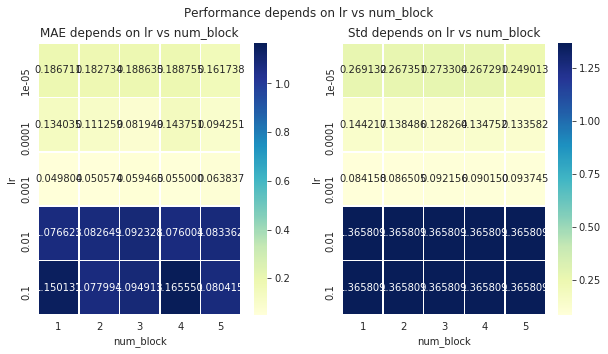

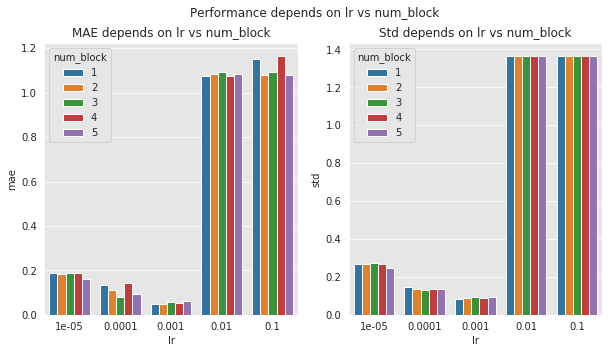

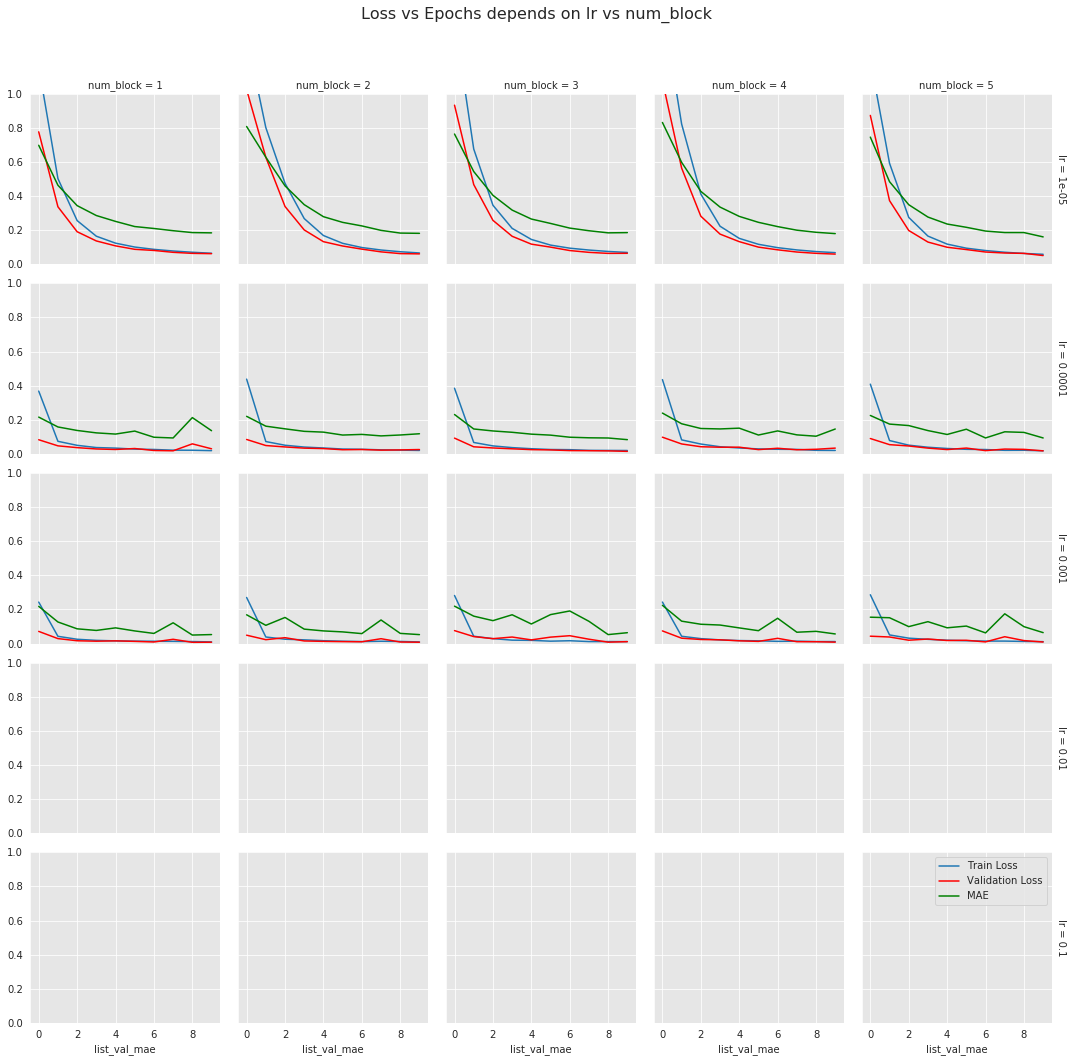

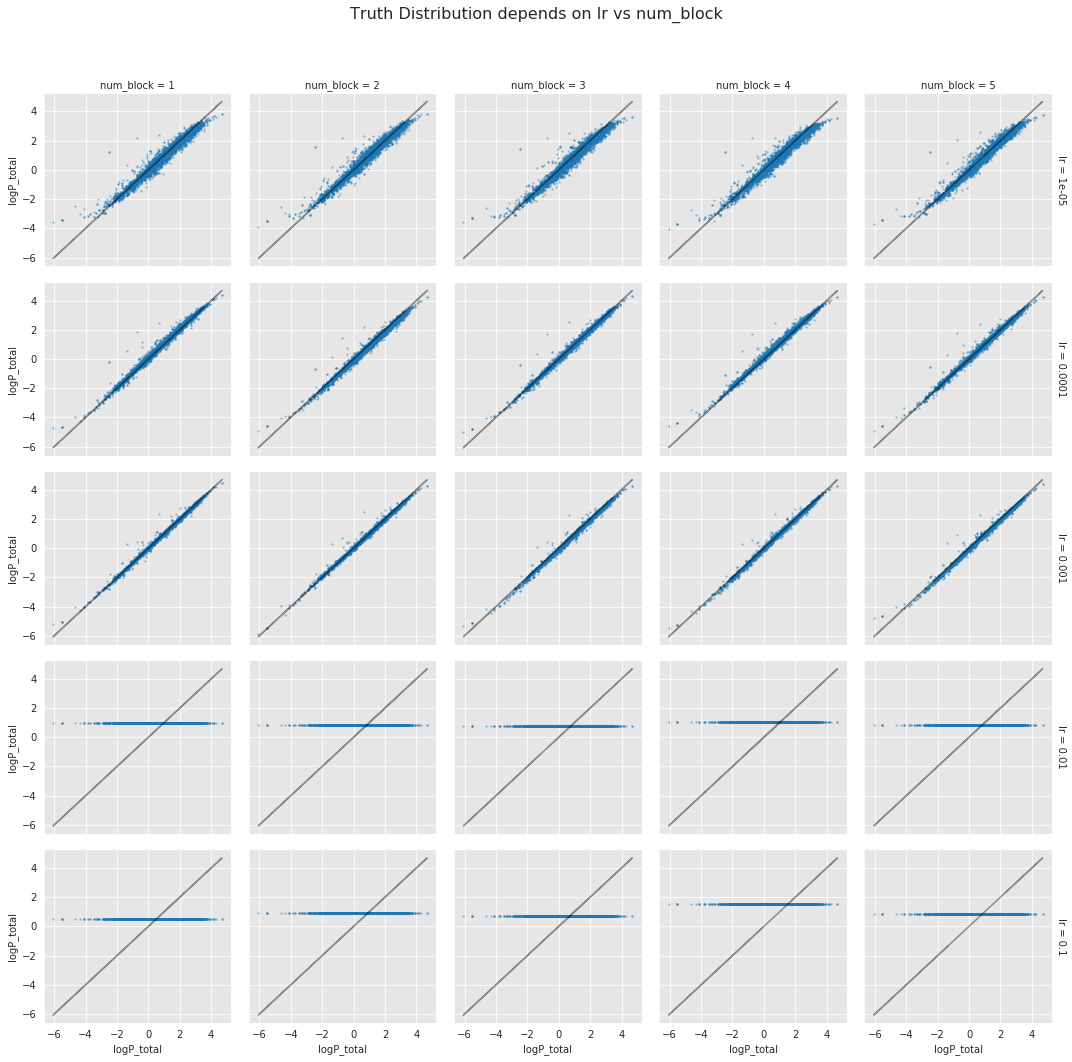

In [129]:
df_result = pd.read_json('lr vs num_block 50000.JSON', orient='table')

plot_performance(df_result, var1, var2)
plot_performance_bar(df_result, var1, var2)
plot_loss(df_result, var1, var2, 1)
plot_distribution(df_result, var1, var2)

In [ ]:
args.optim = 'Adam'
args.epoch = 15

# Learning Rate
args.lr = 0.001
args.step_size = 10
args.gamma = 0.1

# Dimensions
args.in_dim = 58    # num_feature
args.hidden_dim = 128
args.pred_dim1 = 128
args.pred_dim2 = 128
args.pred_dim3 = 64
args.out_dim = 1

# Block and Layers
args.n_block = 1
args.n_layer = 2

# Extras
args.gsc = True
args.l2_coef = 0

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [130]:
list_n_layer = [1, 2, 3, 4, 5]
list_step_size = [3, 5, 10]
var1 = "n_layer"
var2 = "step_size"

dict_result = dict()
n_iter_train = len(dict_partition['train'])
n_iter_val = len(dict_partition['val'])
n_iter = len(list_n_layer)*len(list_step_size)*args.epoch*(n_iter_train+n_iter_val)
bar = tqdm_notebook(total=n_iter, file=sys.stdout, position=0)

for n_layer in list_n_layer:
    for step_size in list_step_size:
        args.n_layer = n_layer
        args.step_size = step_size
        args.exp_name = var1+':'+str(n_layer)+'/'+var2+':'+str(step_size)
        result = vars(experiment(dict_partition, device, bar, args))
        print(args.exp_name + " took " + str(int(args.time_required)) + "seconds.")
        dict_result[args.exp_name] = copy.deepcopy(result)
        
        torch.cuda.empty_cache()
bar.close()

df_result = pd.DataFrame(dict_result).transpose()
df_result.to_json('n_layer vs step_size 50000.JSON', orient='table')

n_layer:1/step_size:3 took 47seconds.
n_layer:1/step_size:5 took 48seconds.
n_layer:1/step_size:10 took 48seconds.
n_layer:2/step_size:3 took 66seconds.
n_layer:2/step_size:5 took 66seconds.
n_layer:2/step_size:10 took 66seconds.
n_layer:3/step_size:3 took 88seconds.
n_layer:3/step_size:5 took 87seconds.
n_layer:3/step_size:10 took 87seconds.
n_layer:4/step_size:3 took 109seconds.
n_layer:4/step_size:5 took 110seconds.
n_layer:4/step_size:10 took 110seconds.
n_layer:5/step_size:3 took 133seconds.
n_layer:5/step_size:5 took 132seconds.
n_layer:5/step_size:10 took 133seconds.



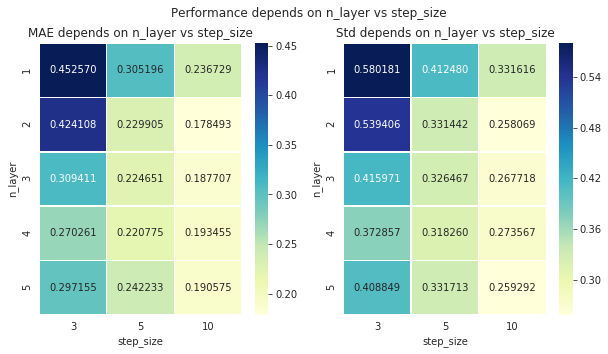

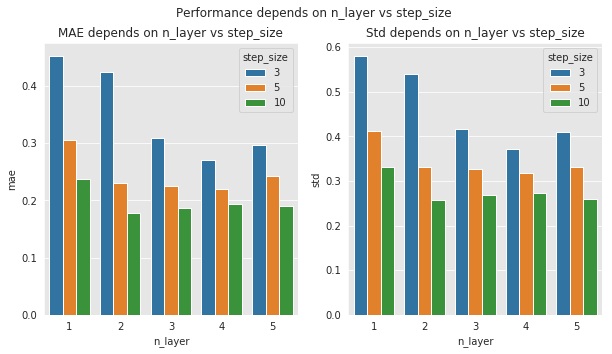

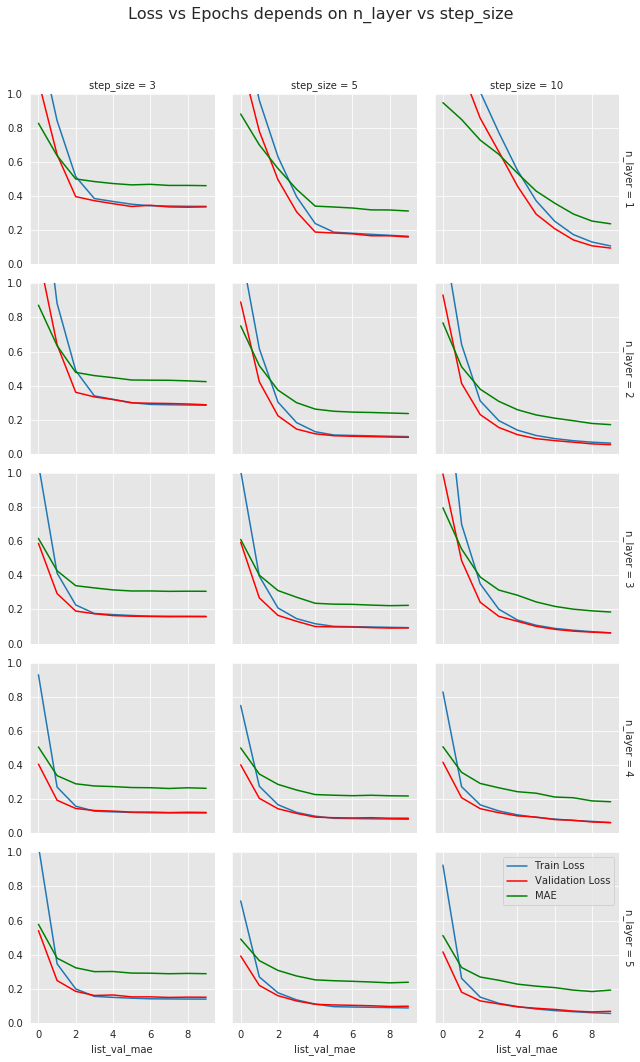

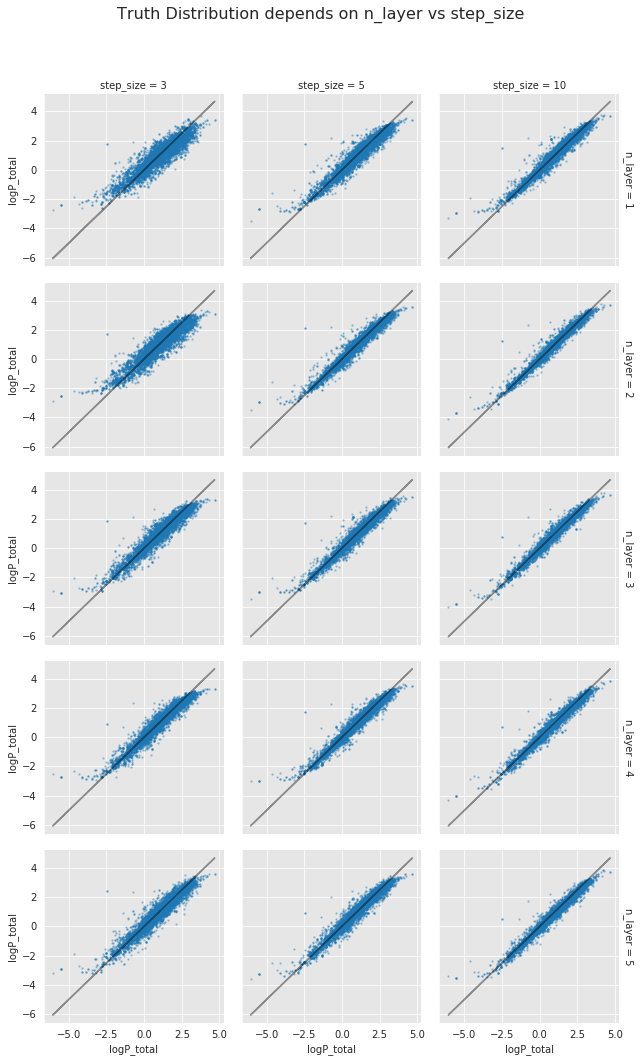

In [131]:
df_result = pd.read_json('n_layer vs step_size 50000.JSON', orient='table')

plot_performance(df_result, var1, var2)
plot_performance_bar(df_result, var1, var2)
plot_loss(df_result, var1, var2, 1)
plot_distribution(df_result, var1, var2)

In [ ]:
args.optim = 'Adam'
args.epoch = 10

# Learning Rate
args.lr = 0.001
args.step_size = 10
args.gamma = 0.1

# Dimensions
args.in_dim = 58    # num_feature
args.hidden_dim = 128
args.pred_dim1 = 128
args.pred_dim2 = 128
args.pred_dim3 = 64
args.out_dim = 1

# Block and Layers
args.n_block = 1
args.n_layer = 2

# Extras
args.gsc = True
args.l2_coef = 0

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [132]:
list_hidden_dim = [64, 128, 256, 512]
list_pred_dim1 = [64, 128, 256, 512]
var1 = "hidden_dim"
var2 = "pred_dim1"

dict_result = dict()
n_iter_train = len(dict_partition['train'])
n_iter_val = len(dict_partition['val'])
n_iter = len(list_hidden_dim)*len(list_pred_dim1)*args.epoch*(n_iter_train+n_iter_val)
bar = tqdm_notebook(total=n_iter, file=sys.stdout, position=0)

for hidden_dim in list_hidden_dim:
    for pred_dim1 in list_pred_dim1:
        args.hidden_dim = hidden_dim
        args.pred_dim1 = pred_dim1
        args.exp_name = var1+':'+str(hidden_dim)+'/'+var2+':'+str(pred_dim1)
        result = vars(experiment(dict_partition, device, bar, args))
        print(args.exp_name + " took " + str(int(args.time_required)) + "seconds.")
        dict_result[args.exp_name] = copy.deepcopy(result)
        
        torch.cuda.empty_cache()
bar.close()

df_result = pd.DataFrame(dict_result).transpose()
df_result.to_json('hidden_dim vs pred_dim1 50000.JSON', orient='table')

hidden_dim:64/pred_dim1:64 took 93seconds.
hidden_dim:64/pred_dim1:128 took 94seconds.
hidden_dim:64/pred_dim1:256 took 93seconds.
hidden_dim:64/pred_dim1:512 took 94seconds.
hidden_dim:128/pred_dim1:64 took 131seconds.
hidden_dim:128/pred_dim1:128 took 132seconds.
hidden_dim:128/pred_dim1:256 took 131seconds.
hidden_dim:128/pred_dim1:512 took 134seconds.
hidden_dim:256/pred_dim1:64 took 248seconds.
hidden_dim:256/pred_dim1:128 took 249seconds.
hidden_dim:256/pred_dim1:256 took 251seconds.
hidden_dim:256/pred_dim1:512 took 252seconds.
hidden_dim:512/pred_dim1:64 took 640seconds.
hidden_dim:512/pred_dim1:128 took 640seconds.
hidden_dim:512/pred_dim1:256 took 643seconds.
hidden_dim:512/pred_dim1:512 took 647seconds.



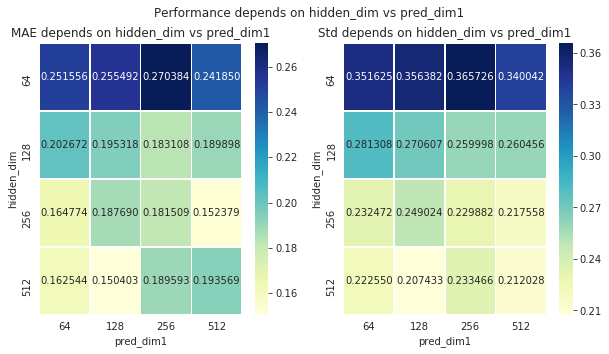

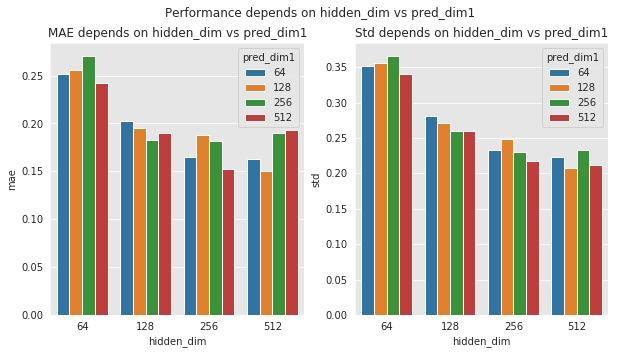

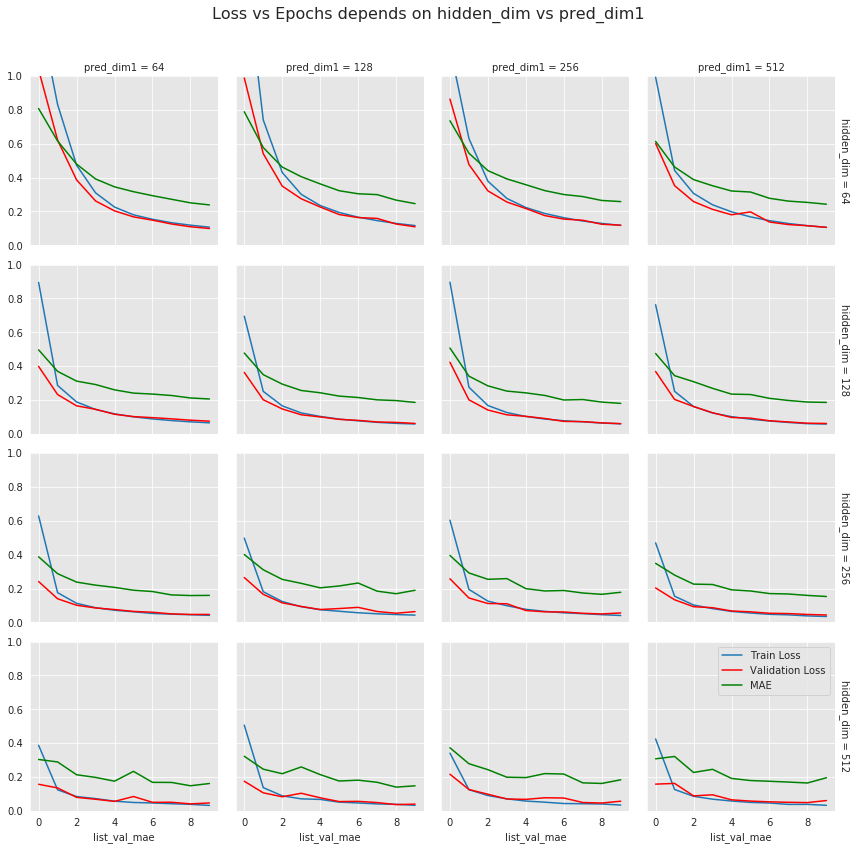

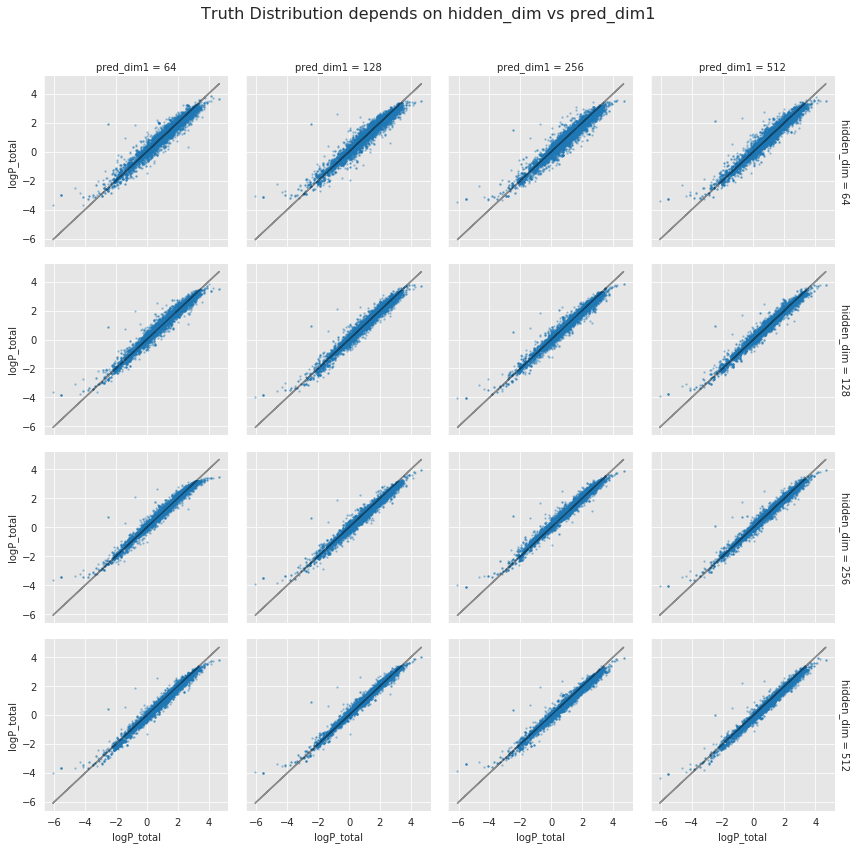

In [134]:
df_result = pd.read_json('hidden_dim vs pred_dim1 50000.JSON', orient='table')

plot_performance(df_result, var1, var2)
plot_performance_bar(df_result, var1, var2)
plot_loss(df_result, var1, var2, 1)
plot_distribution(df_result, var1, var2)

In [139]:
args.optim = 'Adam'
args.epoch = 10

# Learning Rate
args.lr = 0.001
args.step_size = 10
args.gamma = 0.1

# Dimensions
args.in_dim = 58    # num_feature
args.hidden_dim = 512
args.pred_dim1 = 128
args.pred_dim2 = 128
args.pred_dim3 = 64
args.out_dim = 1

# Block and Layers
args.n_block = 2
args.n_layer = 2

# Extras
args.gsc = True
args.l2_coef = 0

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [140]:
list_pred_dim2 = [64, 128, 256]
list_pred_dim3 = [64, 128, 256]
var1 = "pred_dim2"
var2 = "pred_dim3"

dict_result = dict()
n_iter_train = len(dict_partition['train'])
n_iter_val = len(dict_partition['val'])
n_iter = len(list_pred_dim2)*len(list_pred_dim3)*args.epoch*(n_iter_train+n_iter_val)
bar = tqdm_notebook(total=n_iter, file=sys.stdout, position=0)

for pred_dim2 in list_pred_dim2:
    for pred_dim3 in list_pred_dim3:
        args.pred_dim2 = pred_dim2
        args.pred_dim3 = pred_dim3
        args.exp_name = var1+':'+str(pred_dim2)+'/'+var2+':'+str(pred_dim3)
        result = vars(experiment(dict_partition, device, bar, args))
        print(args.exp_name + " took " + str(int(args.time_required)) + "seconds.")
        dict_result[args.exp_name] = copy.deepcopy(result)
        
        torch.cuda.empty_cache()
bar.close()

df_result = pd.DataFrame(dict_result).transpose()
df_result.to_json('pred_dim2 vs pred_dim3 50000.JSON', orient='table')

pred_dim2:64/pred_dim3:64 took 291seconds.
pred_dim2:64/pred_dim3:128 took 292seconds.
pred_dim2:64/pred_dim3:256 took 292seconds.
pred_dim2:128/pred_dim3:64 took 292seconds.
pred_dim2:128/pred_dim3:128 took 292seconds.
pred_dim2:128/pred_dim3:256 took 292seconds.
pred_dim2:256/pred_dim3:64 took 292seconds.
pred_dim2:256/pred_dim3:128 took 292seconds.
pred_dim2:256/pred_dim3:256 took 292seconds.



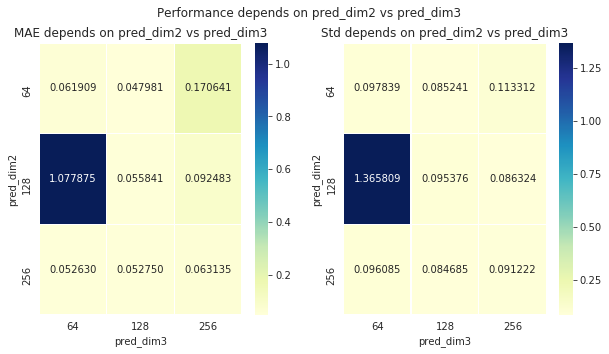

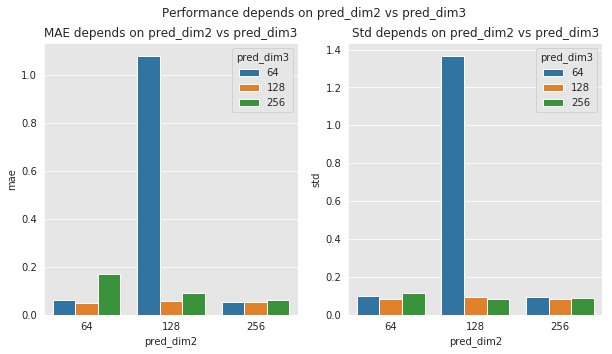

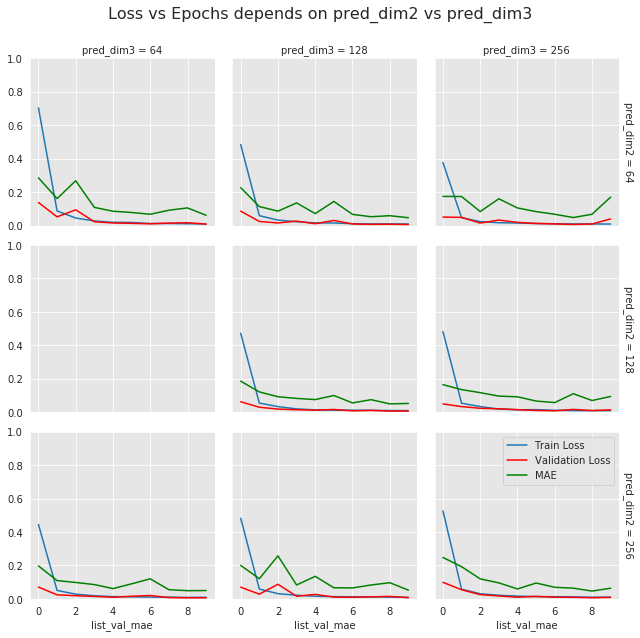

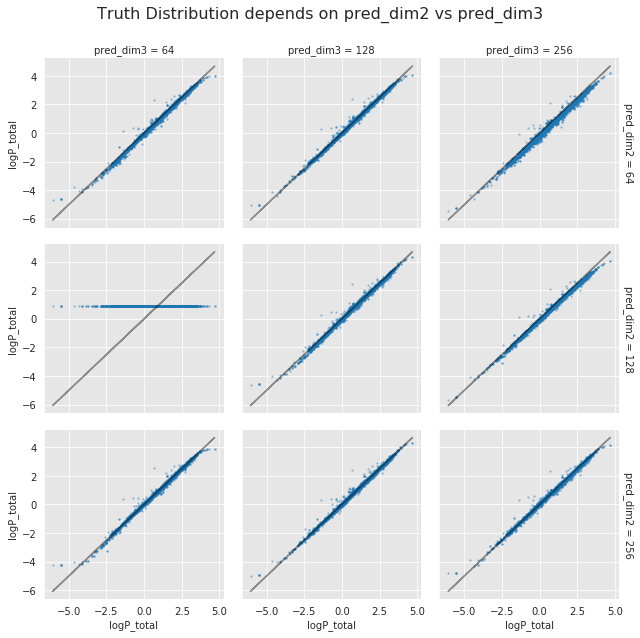

In [141]:
df_result = pd.read_json('pred_dim2 vs pred_dim3 50000.JSON', orient='table')

plot_performance(df_result, var1, var2)
plot_performance_bar(df_result, var1, var2)
plot_loss(df_result, var1, var2, 1)
plot_distribution(df_result, var1, var2)

In [23]:
list_smi, list_logP = read_ZINC_smiles('ZINC.smiles', 190000)
list_feature, list_adj = convert_to_graph(list_smi)
dict_partition = partition(list_feature, list_adj, list_logP, args)

In [26]:
args.optim = 'Adam'
args.batch_size = 128
args.epoch = 50

# Learning Rate
args.lr = 0.001
args.step_size = 10
args.gamma = 0.1

# Dimensions
args.in_dim = 58    # num_feature
args.hidden_dim = 512
args.pred_dim1 = 128
args.pred_dim2 = 64
args.pred_dim3 = 128
args.out_dim = 1

# Block and Layers
args.n_block = 2
args.n_layer = 2

# Extras
args.gsc = True
args.l2_coef = 0

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [27]:
dict_result = dict()
n_iter_train = len(dict_partition['train'])
n_iter_val = len(dict_partition['val'])
n_iter = args.epoch*(n_iter_train+n_iter_val)
bar = tqdm_notebook(total=n_iter, file=sys.stdout, position=0)

args.exp_name = "result 190000"
result = vars(experiment(dict_partition, device, bar, args))
dict_result[args.exp_name] = copy.deepcopy(result)

torch.cuda.empty_cache()
bar.close()

df_result = pd.DataFrame(dict_result).transpose()
df_result.to_json('result 190000.JSON', orient='table')

MAE: 0.0083725358
Std: 0.0321722482


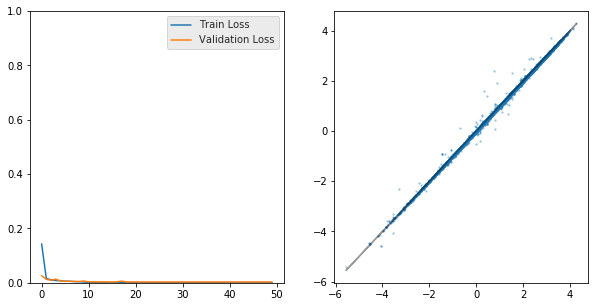

In [28]:
df_result = pd.read_json('result 190000.JSON', orient='table')

print("MAE: " + str(df_result['mae'][0]))
print("Std: " + str(df_result['std'][0]))

fig, ax = plt.subplots(1, 2)
fig.set_size_inches(10, 5)
sns.set_style("darkgrid", {"axes.facecolor": ".9"})

ax[0].plot(df_result['list_train_loss'][0], label='Train Loss')
ax[0].plot(df_result['list_val_loss'][0], label='Validation Loss')
ax[0].set_ylim([0, 1])
ax[0].legend()
ax[1].scatter(df_result['logP_total'][0], df_result['pred_logP_total'][0], alpha=0.3, s=2)
ax[1].plot(df_result['logP_total'][0], df_result['logP_total'][0], color='black', alpha=0.4)